In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
import matplotlib.patches as mpatches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [79]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('muted')
sns.set_context(
    "notebook",
    font_scale=1,
    rc={"lines.linewidth": 2.5}
)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 

In [81]:
import torch
import numpy as np
from statistics import mean 
from scipy.stats import pearsonr

In [44]:
from tools.metrics import *
from tools.utils import *
from models.evidential import *
from sklearn.linear_model import LinearRegression


In [6]:
def get_k(aps, k, top=True):
    idxs = list(enumerate(aps))
    s = sorted(idxs, key=lambda x: x[1], reverse=top)
    res = [index for index, value in s[:k]]

    return s[:k]

In [7]:
pred = torch.load('../test/prediction.pt')
gt = torch.load('../test/ground_truth.pt')
ep = torch.load('../test/epistemic.pt')
ood = torch.load('../test/oods.pt')
raw = torch.load('../test/raw.pt')

In [157]:
m = Evidential([0], backbone="lss")
m.load(torch.load("../outputs/overfitted_demo/79.pt"))

Loaded pretrained weights for efficientnet-b0
Using weights: None
BETA LAMBDA: 0.001


In [ ]:
k=20

In [10]:
aps = []
lo = []
ious = []

for i in range(ep.shape[0]):
    a = ood[i]
    b = ep[i, 0]
    
    if a.sum() == 0: continue
    
    fpr, tpr, rec, pr, auroc, ap, no_skill = roc_pr(b, a)
    aps.append(ap)
    lo.append(m.loss_ood(raw[i].to(4)[None], gt[i].to(4)[None], ood[i].long().to(4)[None])[1].item())
    ious.append(unc_iou(b, a).item())

In [ ]:
topk = get_k(aps, k)
botk = get_k(aps, k, top=False)

In [94]:
def lobf(x, y, xlim, ax):
    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(xlim[0], xlim[1], num=5)
    ax.plot(xseq, a + b * xseq, "--", c='purple', lw=1.5, alpha=.75);

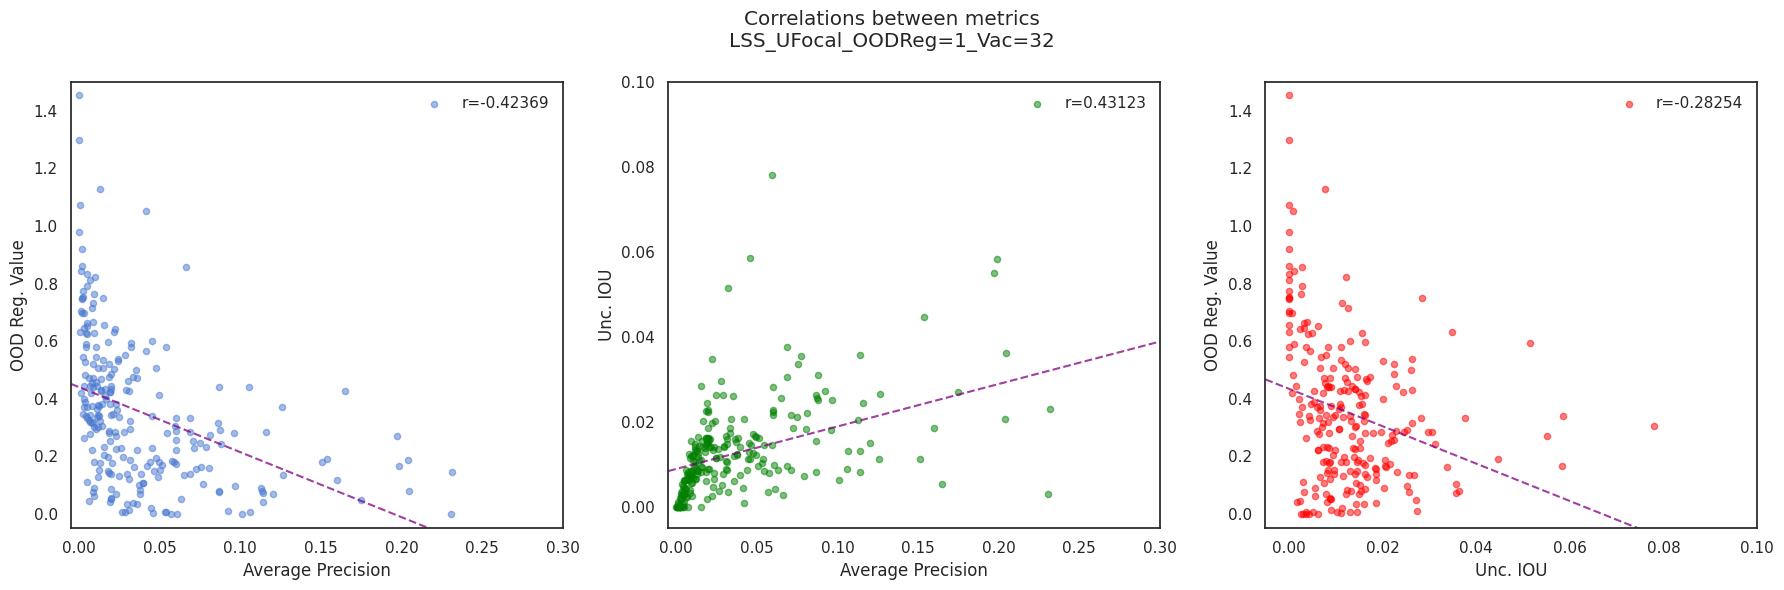

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(aps, lo, label=f"r={pearsonr(aps, lo)[0]:.5f}", s=20, alpha=.5)
axs[0].set_xlabel("Average Precision")
axs[0].set_ylabel("OOD Reg. Value")
axs[0].set_ylim(-0.05, 1.5)
axs[0].set_xlim(-0.005, .3)
lobf(aps, lo, (-.005, .4), axs[0])
axs[0].legend()

axs[1].scatter(aps, ious, c='g', label=f"r={pearsonr(aps, ious)[0]:.5f}", s=20, alpha=.5)
axs[1].set_xlabel("Average Precision")
axs[1].set_ylabel("Unc. IOU")
axs[1].set_ylim(-0.005, .1)
axs[1].set_xlim(-0.005, .3)
lobf(aps, ious, (-.005, .4), axs[1])
axs[1].legend()

axs[2].scatter(ious, lo, c='r', label=f"r={pearsonr(ious, lo)[0]:.5f}", s=20, alpha=.5)
axs[2].set_xlabel("Unc. IOU")
axs[2].set_ylabel("OOD Reg. Value")
axs[2].set_ylim(-0.05, 1.5)
axs[2].set_xlim(-0.005, .1)
lobf(ious, lo, (-.005, .12), axs[2])
axs[2].legend()

fig.suptitle("Correlations between metrics\nLSS_UFocal_OODReg=1_Vac=32")
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(4, k, figsize=(4*k, 20))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(k):
    idx, ap = topk[i]
    
    axs[0, i].set_title(f"AP={ap:.5f}", fontsize=24)
    axs[0, i].imshow(ep[idx, 0], cmap='inferno')
    
    axs[1, i].set_title(f"OOD ratio={ood[idx].numpy().mean():.5f}", fontsize=24)
    axs[1, i].imshow(ood[idx], cmap='viridis')
    
    iou = get_iou(pred[idx].unsqueeze(0), gt[idx].unsqueeze(0), exclude=ood[idx].unsqueeze(0))
    
    axs[2, i].set_title(f"Avg. IOU={mean(iou):.5f}", fontsize=24)
    axs[2, i].imshow(map_rgb(pred[idx], ego=True) / 255)
    axs[3, i].imshow(map_rgb(gt[idx], ego=True) / 255)
    
axs[0, 0].set_ylabel("Epistemic", fontsize=24)
axs[1, 0].set_ylabel("OOD", fontsize=24)
axs[2, 0].set_ylabel("Prediction", fontsize=24)
axs[3, 0].set_ylabel("Label", fontsize=24)

fig.suptitle(f"LSS-UFocal-OODReg\n Top {k} samples with highest AP\nID classes are [vehicle, road, lane, background]\nRows are [epistemic, ood, prediction, label]\n", fontsize=24)    

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(4, k, figsize=(4*k, 20))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(k):
    idx, ap = botk[i]
    
    axs[0, i].set_title(f"AP={ap:.5f}", fontsize=24)
    axs[0, i].imshow(ep[idx, 0], cmap='inferno')
    
    axs[1, i].set_title(f"OOD ratio={ood[idx].numpy().mean():.5f}", fontsize=24)
    axs[1, i].imshow(ood[idx], cmap='viridis')
    
    iou = get_iou(pred[idx].unsqueeze(0), gt[idx].unsqueeze(0), exclude=ood[idx].unsqueeze(0))
    
    axs[2, i].set_title(f"Avg. IOU={mean(iou):.5f}", fontsize=24)
    axs[2, i].imshow(map_rgb(pred[idx], ego=True) / 255)
    axs[3, i].imshow(map_rgb(gt[idx], ego=True) / 255)
    axs[0, i].set_title(f"AP={ap:.5f}", fontsize=24)
    
axs[0, 0].set_ylabel("Epistemic", fontsize=24)
axs[1, 0].set_ylabel("OOD", fontsize=24)
axs[2, 0].set_ylabel("Prediction", fontsize=24)
axs[3, 0].set_ylabel("Label", fontsize=24)

fig.suptitle("LSS-UFocal-OODReg\n Bottom 10 samples with lowest AP\nID classes are [vehicle, road, lane, background]\nRows are [epistemic, ood, prediction, label]\n", fontsize=24)    

fig.tight_layout()

In [141]:
import matplotlib as mpl
from datasets.carla import CarlaDataset

In [144]:
cam_names = [
    "FRONT_LEFT_CAMERA",
    "FRONT_CAMERA",
    "FRONT_RIGHT_CAMERA",
    "BACK_LEFT_CAMERA",
    "BACK_CAMERA",
    "BACK_RIGHT_CAMERA",
]

In [142]:
ood_data = CarlaDataset("../../data/carla/train_aug", False)

In [ ]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val/3*2*rat*3, val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 6, width_ratios=(1, 1, 1, 2*rat, 2*rat, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

save = 'augv_frames'
os.makedirs(save, exist_ok=True)

for i in range(100):
    images, intrinsics, extrinsics, labels, ood = ood_data[i]
    images = images[None].to(4)
    intrinsics = intrinsics[None].to(4)
    extrinsics = extrinsics[None].to(4)
    labels = labels[None].to(4)

    logits = m(images, intrinsics, extrinsics).detach().cpu()
    preds = m.activate(logits)
    
    for ci in range(6):
        ax = plt.subplot(gs[ci // 3, ci % 3])
        plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
        ax.axis('off')
        image = images[0, ci].cpu().permute(1, 2, 0).numpy()
        ax.imshow(image)
            
    ax = plt.subplot(gs[:, 3:4])
    ax.imshow(map_rgb(preds[0]) / 255)
    ax.axis("off")
    
    ax = plt.subplot(gs[:, 4:5])
    ax.imshow(m.epistemic(logits)[0, 0], cmap='magma')
    ax.axis("off")
    
    ax = plt.subplot(gs[:, 5:6])
    ax.imshow(ood, cmap='viridis')
    ax.axis("off")

    fig.savefig(f"{save}/{i}.png")
    plt.clf()


In [158]:

fig = plt.figure(figsize=(10, 7.3125))
gs = mpl.gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, .5])  # Adjust height_ratios
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

blue_patch = mpatches.Patch(color='blue', label='vehicle')
red_patch = mpatches.Patch(color='red', label='road')
green_patch = mpatches.Patch(color='lime', label='lane')
black_patch = mpatches.Patch(color='black', label='background')
purple_patch = mpatches.Patch(color='purple', label='OOD')

save = 'test'
os.makedirs(save, exist_ok=True)

for i in range(3200, 3300):
    images, intrinsics, extrinsics, labels, ood = ood_data[i]
    images = images[None].to(4)
    intrinsics = intrinsics[None].to(4)
    extrinsics = extrinsics[None].to(4)
    labels = labels[None].to(4)

    logits = m(images, intrinsics, extrinsics).detach().cpu()
    preds = m.activate(logits)
    
    for ci in range(6):
        ax = fig.add_subplot(gs[ci // 3, ci % 3])
        plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
        image = images[0, ci].cpu().permute(1, 2, 0).numpy()
        ax.imshow(image)
            
    ax = fig.add_subplot(gs[2:4, 0])
    ax.imshow(map_rgb(preds[0]) / 255)
    ax.set_xlabel("Prediction", fontsize=18)

    ax = fig.add_subplot(gs[2:4, 1])
    ax.imshow(m.epistemic(logits)[0, 0], cmap='magma')
    ax.set_xlabel("Epistemic Unc.", fontsize=18)
    
    l = map_rgb(labels[0]) / 255
    l[ood.bool()] = [.5, 0., .5]
    ax = fig.add_subplot(gs[2:4, 2])
    ax.imshow(l)
    ax.set_xlabel("Ground Truth", fontsize=18)
    
    fig.align_labels()

    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        
    fig.legend(handles=[blue_patch, red_patch, green_patch, black_patch, purple_patch], 
               loc="lower center", 
               bbox_to_anchor=(0.5, 0),
               fontsize=16, 
               ncol=5)
    
    fig.savefig(f"{save}/{i}.png", bbox_inches='tight')
    plt.clf()

<Figure size 1000x731.25 with 0 Axes>

In [194]:
ood_data = CarlaDataset("../../data/carla/train_aug", False)

In [200]:
for images, intrinsics, extrinsics, labels, ood in ood_data:
    l = map_rgb(labels) / 255
    print(l.shape)
    cv2.imwrite(f"./labs/{i}.png", l)

(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 for images, intrinsics, extrinsics, labels, ood in ood_data:                                 │
│   2 │   l = map_rgb(labels) / 255                                                                │
│   3 │   print(l.shape)                                                                           │
│   4 │   cv2.imwrite(f"./labs/{i}.png", l)                                                        │
│                                                                                                  │
│ /data/bny220000/projects/ubev/datasets/carla.py:108 in __getitem__                               │
│                                                                                                  │
│   105 │   │   index = (index + self.offset) % self.ticks                                         │
│   106 │   │                                                                                      │
│   107 │   │   images, intrinsics, extrinsics = self.get_input_data(index, agent_path)            │
│ ❱ 108 │   │   labels, ood = self.get_label(index, agent_path)                                    │
│   109 │   │                                                                                      │
│   110 │   │   if self.return_info:                                                               │
│   111 │   │   │   return images, intrinsics, extrinsics, labels, ood, {                          │
│                                                                                                  │
│ /data/bny220000/projects/ubev/datasets/carla.py:81 in get_label                                  │
│                                                                                                  │
│    78 │   │   empty = np.ones(self.bev_dimension[:2])                                            │
│    79 │   │                                                                                      │
│    80 │   │   road = mask(label, (128, 64, 128))                                                 │
│ ❱  81 │   │   lane = mask(label, (157, 234, 50))                                                 │
│    82 │   │   vehicles = mask(label, (0, 0, 142))                                                │
│    83 │   │                                                                                      │
│    84 │   │   if np.sum(vehicles) < 5:                                                           │
│                                                                                                  │
│ /data/bny220000/projects/ubev/tools/geometry.py:46 in mask                                       │
│                                                                                                  │
│    43                                                                                            │
│    44                                                                                            │
│    45 def mask(img, target):                                                                     │
│ ❱  46 │   m = np.all(img == target, axis=2).astype(int)                                          │
│    47 │   return m                                                                               │
│    48                                                                                            │
│    49                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt